# Implementing and testing the Pr0 function for Hahn Echo measurements

A. Gentile

07/2017

In [1]:
import qinfer as qi
import numpy as np
import scipy as sp
import qutip as qt
import sys, os

In [2]:
import matplotlib.pyplot as plt

# Observation of dynamics induced by different $\hat{H}$ terms

In [3]:
# Add personalized library to PYTHONPATH
import sys, os
sys.path.append(os.path.join("..","Libraries","QML_lib"))

In [4]:
from Norms import *
from IOfuncts import *
from EvalLoss import *

import ProbeStates as pros
import multiPGH as mpgh
import GenSimQMD as gsi
import Evo as evo
import Distrib as distr

In [5]:
import importlib as imp

imp.reload(pros)
imp.reload(mpgh)
imp.reload(gsi)
imp.reload(evo)
imp.reload(distr)

<module 'Distrib' from '..\\Libraries\\QML_lib\\Distrib.py'>

## Simulated data from the model as in (Childress, 2007)

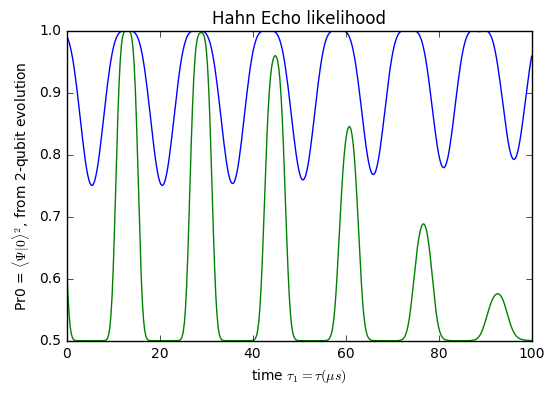

In [907]:
tvec = np.linspace(0.,100,400)
offset = 13.

simsizes = [1, 30]
evolve = np.empty([len(tvec),len(simsizes)])

for simsize in simsizes:
    
#     freqsa = np.repeat(7, simsize) 
    freqsa = np.random.normal(loc=0.398, scale=18*10**-3, size=simsize)   #loc=3, scale=2*10**-3   ///for correct simulation of T2 with ~100 qubits coupled 
    freqsb = np.random.normal(loc=0.39, scale=18*10**-3, size=simsize)    #loc=3, scale=2*10**-3
    
#     freqsa = np.random.normal(loc=5, scale=10**-3, size=simsize)
#     freqsb = np.random.normal(loc=0.5, scale=10**-3, size=simsize)

    for idt in range(len(tvec)):
        
        shifted_t = tvec[idt]-offset
        S = [1 - 0.5*((np.sin(freqsa[i]*shifted_t/2))**2)*((np.sin(freqsb[i]*shifted_t/2))**2)   for i in range(len(freqsa))]
        
        ## checks what happens if the nuclei had precession independent of the electron spin
#         S = [1 - 1*((np.sin(freqsa[i]*tvec[idt]))**2)*((np.sin(freqsa[i]*tvec[idt]))**2)   for i in range(len(freqsa))]

        evolve[idt, simsizes.index(simsize)] = (np.prod(S)+1)/2
                       
plt.plot(tvec, evolve)



#plt.legend(("1 nuclei", "500 nuclei"))

plt.title('Hahn Echo likelihood')
plt.xlabel(r'time $\tau_1 = \tau (\mu s)$')
plt.ylabel(r'Pr0 = $\langle \Psi | 0 \rangle ^2 $, from 2-qubit evolution')

plt.show()

main conclusion is that a single nucleus will not be enough to reproduce T2, yet it should be enough to capture the essence of the $\tau$ decay 

## Standard operators for echo measurements

In [10]:
spinlst = [evo.sigmax(), evo.sigmay(), evo.sigmaz()]    

In [11]:
Hahn_angle = np.pi/2

H_Hahn = np.kron(Hahn_angle*spinlst[2],np.eye(2))

### Single qubit dynamics ($\sigma_i \otimes \mathbb{1}$)

In [557]:
oplist = np.array(list(map(lambda j: np.kron(spinlst[j],np.eye(2)) , range(len(spinlst)))))

In [558]:
probestate = np.kron(evo.plus(), evo.plus())
probestate

array([ 0.5,  0.5,  0.5,  0.5])

In [559]:
tvec = np.linspace(0.,10,400)
evolve = np.empty([len(tvec), len(oplist)])
Rabifreq = 3.0 # expected 7 for Rabi frequency

for j in range(len(oplist)):
    Htot = Rabifreq*oplist[j]

    for idt in range(len(tvec)):

        evostate = np.dot(sp.linalg.expm(-(1j)*tvec[idt]*Htot), probestate)

        evostate = np.dot(sp.linalg.expm(-(1j)*1*H_Hahn), evostate)    # Hahn-echo operation

        evostate = np.dot(sp.linalg.expm(-(1j)*tvec[idt]*Htot), evostate)

        qt_evostate = qt.Qobj(evostate) # transforming into a Qutip object in order to compute partial trace
        qt_evostate.dims = [[2,2],[1,1]]

        ## Partial tracing over the nuclear deg of freedom
        evolve[idt, j] = 1 - qt.expect(qt_evostate.ptrace(0), qt.Qobj(evo.plus()) ) **2

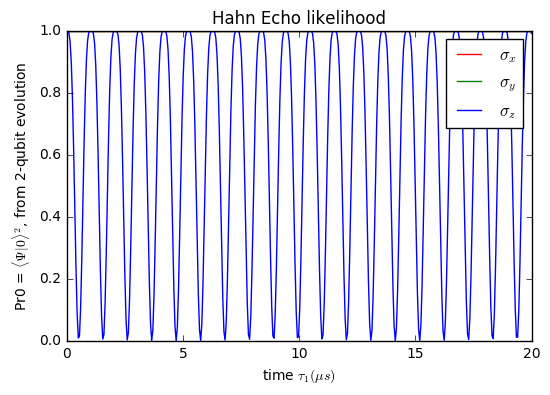

In [562]:
plt.plot(2*tvec, evolve[:,0], "r-")
plt.plot(2*tvec, evolve[:,1], "g-")
plt.plot(2*tvec, evolve[:,2], "b-")

plt.legend(('$\sigma_x$', '$\sigma_y$', '$\sigma_z$' ))

plt.title('Hahn Echo likelihood')
plt.xlabel(r'time $\tau_1 (\mu s)$')
plt.ylabel(r'Pr0 = $\langle \Psi | 0 \rangle ^2 $, from 2-qubit evolution')

plt.show()

### Single qubit dynamics and $\tau'$ driven decay ($\sigma_i \otimes \mathbb{1}$)

In [563]:
oplist = np.array(list(map(lambda j: np.kron(spinlst[j],np.eye(2)) , range(len(spinlst)))))

In [564]:
probestate = np.kron(evo.plus(), evo.plus())
probestate

array([ 0.5,  0.5,  0.5,  0.5])

In [565]:
tvec = np.linspace(0.,10,400)
evolve = np.empty([len(tvec), len(oplist)])
Rabifreq = 7

for j in range(len(oplist)):
    Htot = Rabifreq*oplist[j]

    for idt in range(len(tvec)):

        #evostate = np.dot(sp.linalg.expm(-(1j)*tvec[idt]*Htot), probestate)

        evostate = np.dot(sp.linalg.expm(-(1j)*1*H_Hahn), probestate)    # Hahn-echo operation

        evostate = np.dot(sp.linalg.expm(-(1j)*tvec[idt]*Htot), evostate)

        qt_evostate = qt.Qobj(evostate) # transforming into a Qutip object in order to compute partial trace
        qt_evostate.dims = [[2,2],[1,1]]

        ## Partial tracing over the nuclear deg of freedom
        evolve[idt, j] = 1 - (qt.expect(qt_evostate.ptrace(0), qt.Qobj(evo.plus()) ))**2

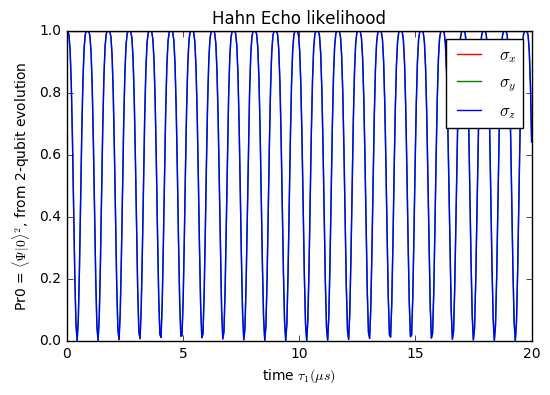

In [570]:
plt.plot(2*tvec, evolve[:,0], "r-")
plt.plot(2*tvec, evolve[:,1], "g-")
plt.plot(2*tvec, evolve[:,2], "b-")

plt.legend(('$\sigma_x$', '$\sigma_y$', '$\sigma_z$' ))

plt.title('Hahn Echo likelihood')
plt.xlabel(r'time $\tau_1 (\mu s)$')
plt.ylabel(r'Pr0 = $\langle \Psi | 0 \rangle ^2 $, from 2-qubit evolution')

plt.show()

### Zero field splitting ($D_{es} \sigma_z^2 \otimes \mathbb{1}$)

In [571]:
Des = 3
Rabifreq = 2.0

In [572]:
probestate = np.kron(evo.plus(), evo.plus())
probestate

array([ 0.5,  0.5,  0.5,  0.5])

In [573]:
tvec = np.linspace(0.,10,200)
evolve = np.empty([len(tvec), len(oplist)])

for j in range(len(oplist)): 
    Htot = np.kron(Rabifreq*spinlst[j] + Des*(spinlst[2])**2,np.eye(2))
    
    for idt in range(len(tvec)):

        evostate = np.dot(sp.linalg.expm(-(1j)*tvec[idt]*Htot), probestate)

        evostate = np.dot(sp.linalg.expm(-(1j)*1*H_Hahn), evostate)    # Hahn-echo operation

        evostate = np.dot(sp.linalg.expm(-(1j)*tvec[idt]*Htot), evostate)

        qt_evostate = qt.Qobj(evostate) # transforming into a Qutip object in order to compute partial trace
        qt_evostate.dims = [[2,2],[1,1]]

        ## Partial tracing over the nuclear deg of freedom
        evolve[idt, j] = 1 - (qt.expect(qt_evostate.ptrace(0), qt.Qobj(evo.plus()) ))**2

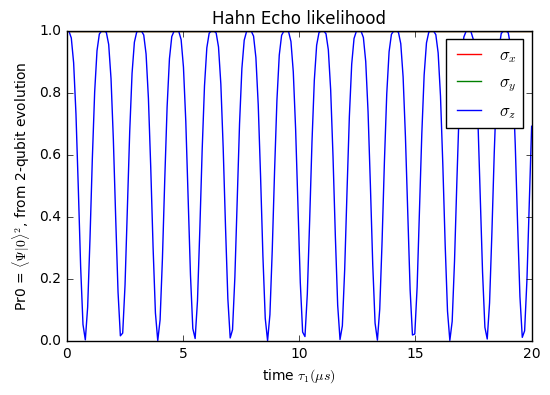

In [574]:
plt.plot(2*tvec, evolve[:,0], "r-")
plt.plot(2*tvec, evolve[:,1], "g-")
plt.plot(2*tvec, evolve[:,2], "b-")

plt.legend(('$\sigma_x$', '$\sigma_y$', '$\sigma_z$' ))

plt.title('Hahn Echo likelihood')
plt.xlabel(r'time $\tau_1 (\mu s)$')
plt.ylabel(r'Pr0 = $\langle \Psi | 0 \rangle ^2 $, from 2-qubit evolution')

plt.show()

### Hyperfine coupling alone ($\hat \sigma_j \otimes \hat I_j$)

In [575]:
oplist = np.array(list(map(lambda j: np.kron(spinlst[j],spinlst[j]), range(len(spinlst)))))

In [576]:
probestate = np.kron(evo.plus(), evo.plus())
probestate

array([ 0.5,  0.5,  0.5,  0.5])

In [577]:
tvec = np.linspace(0.,10,200)
evolve = np.empty([len(tvec), len(oplist)])

HfA = 1.0

for j in range(len(oplist)):
    Htot = HfA*oplist[j]

    for idt in range(len(tvec)):

        evostate = np.dot(sp.linalg.expm(-(1j)*tvec[idt]*Htot), probestate)

        evostate = np.dot(sp.linalg.expm(-(1j)*1*H_Hahn), evostate)    # Hahn-echo operation

        evostate = np.dot(sp.linalg.expm(-(1j)*tvec[idt]*Htot), evostate)

        qt_evostate = qt.Qobj(evostate) # transforming into a Qutip object in order to compute partial trace
        qt_evostate.dims = [[2,2],[1,1]]

        ## Partial tracing over the nuclear deg of freedom
        evolve[idt, j] = 1 - (qt.expect(qt_evostate.ptrace(0), qt.Qobj(evo.plus()) ))**2

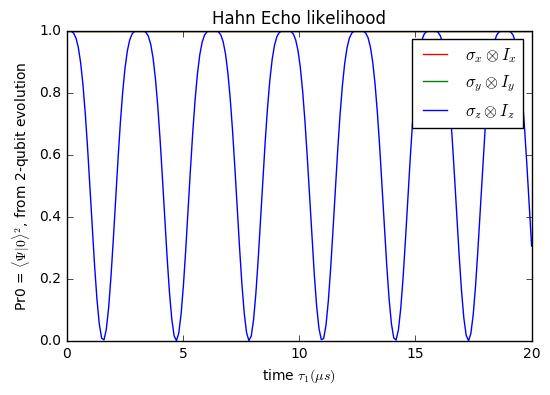

In [578]:
plt.plot(2*tvec, evolve[:,0], "r-")
plt.plot(2*tvec, evolve[:,1], "g-")
plt.plot(2*tvec, evolve[:,2], "b-")

plt.legend(('$\sigma_x \otimes I_x$', '$\sigma_y \otimes I_y$', '$\sigma_z \otimes I_z$' ))

plt.title('Hahn Echo likelihood')
plt.xlabel(r'time $\tau_1 (\mu s)$')
plt.ylabel(r'Pr0 = $\langle \Psi | 0 \rangle ^2 $, from 2-qubit evolution')

plt.show()

### Hyperfine coupling with $\tau'$ driven decay ($\hat \sigma_j \otimes \hat I_j$)

In [598]:
oplist = np.array(list(map(lambda j: np.kron(spinlst[j],spinlst[j]), range(len(spinlst)))))

In [599]:
probestate = np.kron(evo.plus(), evo.plus())
probestate

array([ 0.5,  0.5,  0.5,  0.5])

In [603]:
tvec = np.linspace(0.,2,200)
evolve = np.empty([len(tvec), len(oplist)])

HfA = np.array([-2.7, -2.7, -2.14])

for j in range(len(oplist)):
    Htot = np.tensordot(HfA, oplist, axes=1)

    for idt in range(len(tvec)):

        #evostate = np.dot(sp.linalg.expm(-(1j)*tvec[idt]*Htot), probestate)
        evostate = probestate

        evostate = np.dot(sp.linalg.expm(-(1j)*1*H_Hahn), evostate)    # Hahn-echo operation

        evostate = np.dot(sp.linalg.expm(-(1j)*tvec[idt]*Htot), evostate)

        qt_evostate = qt.Qobj(evostate) # transforming into a Qutip object in order to compute partial trace
        qt_evostate.dims = [[2,2],[1,1]]

        ## Partial tracing over the nuclear deg of freedom
        evolve[idt, j] = 1 - (qt.expect(qt_evostate.ptrace(0), qt.Qobj(evo.plus()) ))**2

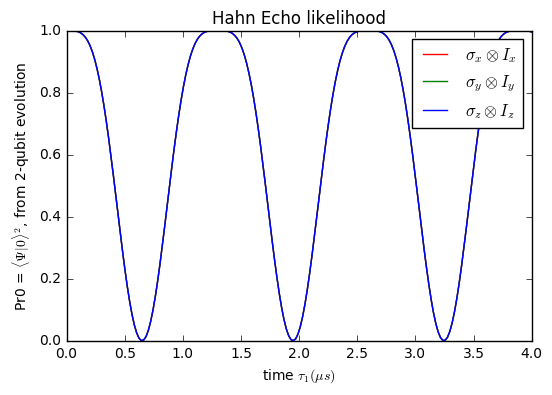

In [604]:
plt.plot(2*tvec, evolve[:,0], "r-")
plt.plot(2*tvec, evolve[:,1], "g-")
plt.plot(2*tvec, evolve[:,2], "b-")

plt.legend(('$\sigma_x \otimes I_x$', '$\sigma_y \otimes I_y$', '$\sigma_z \otimes I_z$' ))

plt.title('Hahn Echo likelihood')
plt.xlabel(r'time $\tau_1 (\mu s)$')
plt.ylabel(r'Pr0 = $\langle \Psi | 0 \rangle ^2 $, from 2-qubit evolution')

plt.show()

### Hyperfine coupling and spin precession ($\hat \sigma_k \otimes \mathbb{1} + \hat \sigma_j \otimes \hat I_j$)

In [779]:
eoplist = np.array(list(map(lambda j: np.kron(spinlst[j],np.eye(2)) , range(len(spinlst)))))

bathoplist = np.array(list(map(lambda j: np.kron(np.eye(2),spinlst[j]) , range(len(spinlst)))))

HFoplist = np.array(list(map(lambda j: np.kron(spinlst[j],spinlst[j]), range(len(spinlst)))))

In [780]:
probestate = np.kron(evo.plus(), evo.plus())
probestate

array([ 0.5,  0.5,  0.5,  0.5])

- the bigger Bathfreq compared to HfA : > the less the visibility in the fringes > the less noise in the oscillations > frequency appears unaltered by any choice of the Bathfreq parameters
- HfAs must also be of the same order of magnitude: a much bigger value of any of them decreases very rapidly the visibility


In [837]:
tvec = np.linspace(0.,10,400)

irange = 1
evolve = np.empty(len(tvec))

# to reproduce the 1spin double cosine oscillations>
#HfA = [-2.9, -2.69, -2.88]
HfA = [-0.65, -0.65, -0.55]

Bathfreq = [3,3,2]


# rich dynamics due to beatings>
#Bathfreq = [3.,2.,8.]

# RabifreqX = 1 #3.8 
# RabifreqY = 1 #1.4
# RabifreqZ =1 #0.22

for myvariable in np.linspace(0.,100, irange):
    
    """Dynamics on the nuclear spin"""
    Htot =  np.tensordot(HfA, HFoplist, axes=1) +  np.tensordot(Bathfreq, bathoplist, axes=1)
    #Htot =  HfAx*HFoplist[0] + HfAy*HFoplist[1] + HfAz*HFoplist[2]+ RabifreqX*eoplist[0] + RabifreqY*eoplist[1] + RabifreqZ*eoplist[2] 

    for idt in range(len(tvec)):

        evostate = np.dot(sp.linalg.expm(-(1j)*tvec[idt]*Htot), probestate)

        evostate = np.dot(sp.linalg.expm(-(1j)*1*H_Hahn), evostate)    # Hahn-echo operation

        evostate = np.dot(sp.linalg.expm(-(1j)*tvec[idt]*Htot), evostate)

        qt_evostate = qt.Qobj(evostate) # transforming into a Qutip object in order to compute partial trace
        qt_evostate.dims = [[2,2],[1,1]]

        ## Partial tracing over the nuclear deg of freedom
        evolve[idt] = 1-(qt.expect(qt_evostate.ptrace(0), qt.Qobj(evo.plus()) ))**2

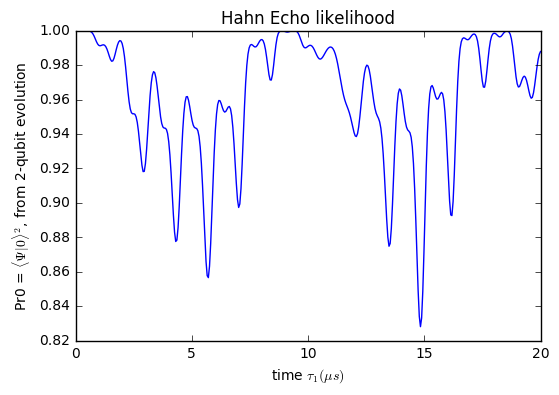

In [838]:
plt.plot(2*tvec, evolve)

plt.title('Hahn Echo likelihood')
plt.xlabel(r'time $\tau_1 (\mu s)$')
plt.ylabel(r'Pr0 = $\langle \Psi | 0 \rangle ^2 $, from 2-qubit evolution')

plt.show()

### Hyperfine coupling and spin precession and $\tau_1$ decay
($\hat \sigma_k \otimes \mathbb{1} + \hat \sigma_j \otimes \hat I_j$)

In [528]:
eoplist = np.array(list(map(lambda j: np.kron(spinlst[j],np.eye(2)) , range(len(spinlst)))))

bathoplist = np.array(list(map(lambda j: np.kron(np.eye(2),spinlst[j]) , range(len(spinlst)))))

HFoplist = np.array(list(map(lambda j: np.kron(spinlst[j],spinlst[j]), range(len(spinlst)))))

In [529]:
probestate = np.kron(evo.plus(), evo.plus())
probestate

array([ 0.5,  0.5,  0.5,  0.5])

In [533]:
tvec = np.linspace(0.,1.6,800)

irange = 1
evolve = np.empty([len(tvec), irange])

HfAx = 2.9
HfAy = 2.7
HfAz = 1.9

BathfreqX = 3 #10
BathfreqY = 0.87 #1000 #70
BathfreqZ = 0.9 #1750

# RabifreqX = 1 #3.8 
# RabifreqY = 1 #1.4
# RabifreqZ =1 #0.22

myvariables = np.ndarray.tolist(np.linspace(-1.5,3.0, irange))

for myvariable in myvariables:
    
    #HfAy = myvariable
    
    """Dynamics on the nuclear spin"""
    Htot =  HfAx*HFoplist[0] + HfAy*HFoplist[1] + HfAz*HFoplist[2] + BathfreqX*bathoplist[0] + BathfreqY*bathoplist[1] + BathfreqZ*bathoplist[2] 
    #Htot =  HfAx*HFoplist[0] + HfAy*HFoplist[1] + HfAz*HFoplist[2]+ RabifreqX*eoplist[0] + RabifreqY*eoplist[1] + RabifreqZ*eoplist[2] 

    for idt in range(len(tvec)):

        #evostate = np.dot(sp.linalg.expm(-(1j)*tvec[idt]*Htot), probestate)
        evostate = probestate

        evostate = np.dot(sp.linalg.expm(-(1j)*1*H_Hahn), evostate)    # Hahn-echo operation

        evostate = np.dot(sp.linalg.expm(-(1j)*tvec[idt]*Htot), evostate)

        qt_evostate = qt.Qobj(evostate) # transforming into a Qutip object in order to compute partial trace
        qt_evostate.dims = [[2,2],[1,1]]

        ## Partial tracing over the nuclear deg of freedom
        
        evolve[idt, myvariables.index(myvariable)] = 1-(qt.expect(qt_evostate.ptrace(0), qt.Qobj(evo.plus()) ))**2


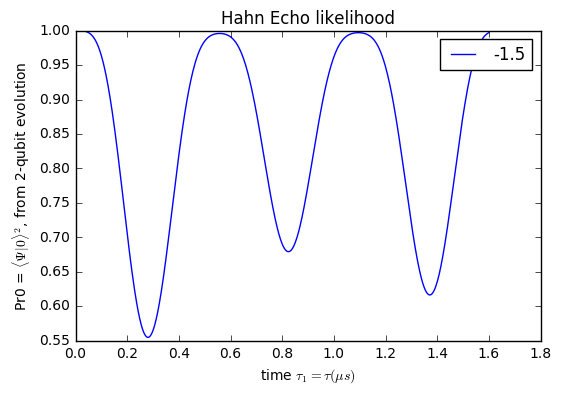

In [534]:
plt.plot(tvec, evolve)

plt.legend((myvariables))

plt.title('Hahn Echo likelihood')
plt.xlabel(r'time $\tau_1 = \tau (\mu s)$')
plt.ylabel(r'Pr0 = $\langle \Psi | 0 \rangle ^2 $, from 2-qubit evolution')

plt.show()

### Dynamics of wrong elements ($\hat \sigma_k \otimes \hat I_j$)

In [305]:
wrongoplist = []
for i in range(2):
    for j in range(i+1, 3):
        print(i,j)
        wrongoplist.append( np.kron(spinlst[i],spinlst[j]) + np.kron(spinlst[j],spinlst[i]) )
wrongoplist = np.array(wrongoplist)
wrongoplist

0 1
0 2
1 2


array([[[ 0.+0.j,  0.+0.j,  0.+0.j,  0.-2.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+2.j,  0.+0.j,  0.+0.j,  0.+0.j]],

       [[ 0.+0.j,  1.+0.j,  1.+0.j,  0.+0.j],
        [ 1.+0.j,  0.+0.j,  0.+0.j, -1.+0.j],
        [ 1.+0.j,  0.+0.j,  0.+0.j, -1.+0.j],
        [ 0.+0.j, -1.+0.j, -1.+0.j,  0.+0.j]],

       [[ 0.+0.j,  0.-1.j,  0.-1.j,  0.-0.j],
        [ 0.+1.j,  0.+0.j,  0.+0.j,  0.+1.j],
        [ 0.+1.j,  0.+0.j,  0.+0.j,  0.+1.j],
        [ 0.+0.j,  0.-1.j,  0.-1.j, -0.+0.j]]])

In [306]:
probestate = np.kron(evo.plus(), evo.plus())
probestate

array([ 0.5,  0.5,  0.5,  0.5])

In [307]:
tvec = np.linspace(0.,10,400)

evolve = np.empty([len(tvec), len(wrongoplist)])

WGfreq = 1 

for j in range(len(wrongoplist)):
    Htot = WGfreq*wrongoplist[j]
    
    for idt in range(len(tvec)):

        evostate = np.dot(sp.linalg.expm(-(1j)*tvec[idt]*Htot), probestate)

        evostate = np.dot(sp.linalg.expm(-(1j)*1*H_Hahn), evostate)    # Hahn-echo operation

        evostate = np.dot(sp.linalg.expm(-(1j)*tvec[idt]*Htot), evostate)

        qt_evostate = qt.Qobj(evostate) # transforming into a Qutip object in order to compute partial trace
        qt_evostate.dims = [[2,2],[1,1]]

        ## Partial tracing over the nuclear deg of freedom
        evolve[idt, j] = qt.expect(qt_evostate.ptrace(0), qt.Qobj(evo.minus()) )

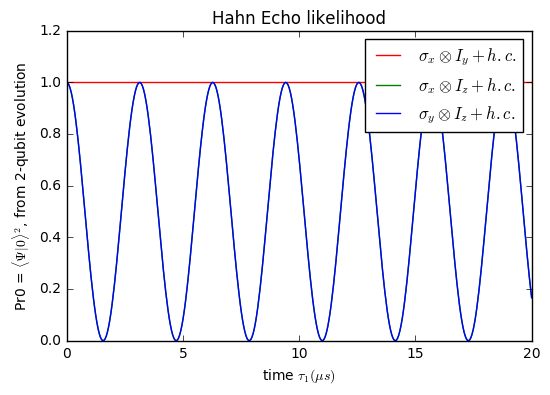

In [308]:
plt.plot(2*tvec, evolve[:,0], "r-")
plt.plot(2*tvec, evolve[:,1], "g-")
plt.plot(2*tvec, evolve[:,2], "b-")

plt.legend(('$\sigma_x \otimes I_y +h.c.$', '$\sigma_x \otimes I_z+h.c.$', '$\sigma_y \otimes I_z+h.c.$' ))

plt.title('Hahn Echo likelihood')
plt.xlabel(r'time $\tau_1 (\mu s)$')
plt.ylabel(r'Pr0 = $\langle \Psi | 0 \rangle ^2 $, from 2-qubit evolution')

plt.show()

$\textit{evolution only under Hp (Hahn echo operation not effectively included)}$
- the evolution is strongly dependent on the choice of the initial (random) nuclei probestate. It is affected only by $\sigma_z \otimes \sigma_z$ and $\sigma_y \otimes \sigma_y$, therefore $A_{//,x}$ has no effect on the evolution. 
- Ignore this possibility, as it would be difficult to justify control/readout of the nuclei spin at the beginning/end of the evolution?

$\textit{evolution under Hp full Hahn echo}$

with Hm = np.kron(np.pi/2*spinlst[2],np.eye(2)) we assume the nuclear spin is static throughout the whole evolution

- evolution independent of the initial choice of the nuclear probe state (ideally because of the $\pi$ flip on the equator, which should be good to us)
- $A_{//,z}$ is of order 6 MHz to reproduce experimental periodicity of Seb's thesis (** never mind, I had adopted $\mu s$ instead of $ns$ in your data!!! Unfortunately though, I do have a degeneracy in the sign, so I cannot estimate whether it is + VS -**). However this seems now far from the 0.214 MHz value for Sangtawesin thesis.

- it is also well protected from "noise" introduced by altering the choice of the initial state at the beginning of each step in the evolution, unless errors in the Hahn angle rotation are introduced
- as such, there is no way to reduce the "visibility" of the oscillations in $\langle \Psi | 0 \rangle ^2 $ by clever choices of the probe state at the beginning
- evolution depends only on the $\sigma_z \otimes \sigma_z$ term of the $H_f$ interaction, so it is effectively a 1-parameter estimate. $A_{//,x}$ has no effect on the evolution as the system is prepared in $|+\rangle$ (well, ideally), whereas $A_{//,y}$ is ruled out by the $\pi$ flip **therefore correct, $A_{\perp,z}$ in this configuration is the dominant effect in the oscillatory behaviour generated by $H_f$**


- I call (improperly I guess, just to make things easier) hereafter "visibility" the amplitude of the oscillations in the PL observed in the data

- **if it was not for the Hahn echo, we could have beatings in the oscillations (that would not be screened from $A_{//,x}$ and $A_{//,y}$, and these beatings could explain different frequencies and the reduced visibility at the beginning of the evolution. However, because of the Hahn echo procedure this seems not the case, unless the partial trace is doing something weird** 
- however, we can introduce an error in the $\pi$ rotation to both simulate decoherence and visibility effects. This is not very useful to me, because: i) it must be a huge one to match experimental data (around $\sim 0.2$ rad); ii) I do not see why this error should increase with time
- more interestingly, $\textit{visibility}$ can be reduced by introducing $\sigma_x$ or $\sigma_y$ terms in the nuclear Hamiltonian (i.e. they effectively undergo a precession). It can also adjust the frequency of the fringes.
- if the trick as above is deemed unacceptable, then the $\textit{offset}$ must be introduced artificially to decrease visibility... is that OK? 

Question 1: do we NOT expect full visibility at all (but full visibility naturally arises from the coupling to the additional spin, I see no other physical reason to reduce the expectetion value of $| \langle 0 | \Psi_{evo} \rangle |^2$?

- as for the $\textit{decoherence}$, the most trivial way is to impose it as an external parameter $T_2$ straight in the final expectation value. However this brings no advantage to multi qubit model (it can be well implemented also in the 1 qubit one). 
- choosing the probestate at the beginning of the evolution, altering the ratio of the two Hahn echo sequences has no effect. Also, I do not see as above why this ratio should be more prone to errors for longer evolution times.
- I have modified the code to include a $\textit{depolarising channel}$ as a unitary mapping (to be specific a **phase damping** as from Preskill notes). This ideally involves a 4-dim environment space for a single qubit, i.e. too big for our system. I was trying to capture the effect with a smaller 2dim space, and I hope this would make referees not too annoyed by discrepancies between ideal case and experimentally accomplished case. However, the Hamiltonian would NOT be anymore just the hyperfine interaction. **Something weird seeems happening with the partial tracing as implemented in Python, I need to do some debugging to solve this.**


Question 2: do we want to use decoherence as well to make less likely to succeed the 1-qubit models? I think the idea is a nice selling point, but at the expense of learning the hyperfine Hamiltonian. Or they would be two different competitive models. Also, is it ok to analyse just partially a depolarising channel? We can hope that simulations favour the 2-qubits but this is not granted.

Given a (perfect) Hahn-echo dynamics, $^1\sigma_{x,y}$ should raise no effect on the state, whereas $^1\sigma_{z}$ gives rise to usual Rabi oscillations

Including the usual "identity" terms in Hp, we introduce unwanted beatings

In [193]:
# Implement a phase damping channel UNITARY (do NOT exp!)
def deco1q(t, Gamma):
    return np.array([[np.sqrt(1- Gamma*t),np.sqrt(Gamma*t),0,0],
                   [np.sqrt(Gamma*t),np.sqrt(1- Gamma*t),0,0],
                   [0,0,np.sqrt(1- Gamma*t),np.sqrt(Gamma*t)],
                   [0,0,np.sqrt(Gamma*t),np.sqrt(1- Gamma*t)]])

t = 0.1
Gamma = 0.02
print(deco1q(t, Gamma))
print("Is Unitary? " + str(np.all(deco1q(t, Gamma).conj().T==deco1q(t, Gamma))))

[[ 0.9989995   0.04472136  0.          0.        ]
 [ 0.04472136  0.9989995   0.          0.        ]
 [ 0.          0.          0.9989995   0.04472136]
 [ 0.          0.          0.04472136  0.9989995 ]]
Is Unitary? True


In [11]:
probestate=np.dot(deco1q(t, Gamma),probestate)

checking that Hproj actually projects back to $|0\rangle$ [evo.zero]

In [12]:
Hproj = np.kron(np.pi/4*spinlst[1],np.eye(2))

In [13]:
evostate = np.dot(sp.linalg.expm(-(1j)*1*Hproj), probestate)
qt_evostate = qt.Qobj(evostate)
qt_evostate.dims = [[2,2],[1,1]]
qt.expect(qt_evostate.ptrace(0), qt.Qobj(evo.zero()) )

0.0

In [14]:
qt_probestate = qt.Qobj(probestate)
qt_probestate.dims = [[2,2],[1,1]]
qt_probestate

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.3124921+0.07049076j]
 [ 0.4474275+0.47344133j]
 [ 0.3124921+0.07049076j]
 [ 0.4474275+0.47344133j]]

In [15]:
qt_probestate.ptrace(0)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.52695831  0.52695831]
 [ 0.52695831  0.52695831]]

In [16]:
qt.expect(qt_probestate.ptrace(0), qt.Qobj(evo.plus()) )

1.0539166295561193